In [1]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)



In [17]:
data = pd.read_csv('./data/dan_table.csv')
data2 = data[(data['RecordLoc'] == 2)]

# TrialStart = 0, 1. much more TrialStart == 0 than ==1 
# First lick: Reward Enter
# Next lick: Reward Exit (after they havne't licked for a while) -- not super reliable 

In [18]:
def normalize(x, mu, std):
    return (x - mu) / std

for mouse_id in np.unique(data2['MouseID']):
    mice_gcamp = data2[data2['MouseID'] == mouse_id]['gcamp'].values
    mice_mu = (np.mean(mice_gcamp))
    mice_std = (np.std(mice_gcamp))
    
    data2.loc[data2['MouseID'] == mouse_id, 'gcamp'] = normalize(mice_gcamp, mice_mu, mice_std)


/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
%%time
# pull out trial by trial info 

data_t = []

for mouse_id in np.unique(data2['MouseID']):
    data_small = data2[data2['MouseID'] == mouse_id]


    trial_starts = np.where(data_small['TrialStart'] == 1)[0]

    
    num_trials = len(trial_starts)

    for t_i, t in enumerate(trial_starts):
        



        if t_i == (num_trials - 1):
            trial_end = len(data_small)
        else:
            trial_end = trial_starts[t_i + 1]

        data_trial = data_small[t:trial_end];
        
        # get gcamp after nose poke enter and before lever press 
        npe_i = np.where(data_trial['NosePokeEnter'] == 1)[0][0]
        lp_i = np.where(data_trial['LeverPresentation'] == 1)[0][0]
        gcamp_pre_lever = data_trial['gcamp'].values[npe_i:lp_i]
        


        
        # check choice and record time between lever and choice 
        if sum(data_trial.IpsLeverPress.values) >  sum(data_trial.ConLeverPress.values):
            action = 'Ips'
            choice_i = np.where(data_trial['IpsLeverPress'] == 1)[0][0]
        else:
            action = 'Con'
            choice_i = np.where(data_trial['ConLeverPress'] == 1)[0][0]
        gcamp_pre_choice = data_small['gcamp'].values[lp_i:choice_i]
        
        
        # check if mice is rewarded 
        if sum(data_trial.CSplus.values) >  sum(data_trial.CSneg.values):
            reward = 1
            reward_i = np.where(data_trial['CSplus'] == 1)[0][0]
            reward_end_i =  np.where(data_trial['RewardExit'] == 1)[0][0]
            gcamp_post_choice = data_trial['gcamp'].values[choice_i:reward_end_i]
        else:
            reward = 0
            reward_i = np.where(data_trial['CSneg'] == 1)[0][0]
            gcamp_post_choice = data_trial['gcamp'].values[choice_i:trial_end]
        delay = reward_i - choice_i
        
        # get timelocked gcamp to nose-poke
        LEN_BEFORE_NP = 50
        LEN_AFTER_NP = 123
        tstart_i_by_np = (npe_i - LEN_BEFORE_NP)
        gcamp_np = data_small['gcamp'].values[(t + npe_i - LEN_BEFORE_NP): (t + npe_i + LEN_AFTER_NP)]
        
        if (len(gcamp_np) < 50):
            import pdb; pdb.set_trace()
        
        # get timelocked gcamp to lp 
        LEN_BEFORE_LP = 50
        LEN_AFTER_LP = 123
        np_i_by_lp = (npe_i - (lp_i - LEN_BEFORE_LP))
        gcamp_lp = data_small['gcamp'].values[(t + lp_i - LEN_BEFORE_LP): (t + lp_i + LEN_AFTER_LP)]
        
        
        # get timelocked gcamp to choice
        LEN_BEFORE_C = 50
        LEN_AFTER_C = 123
        lp_i_by_choice = lp_i - (choice_i - LEN_BEFORE_C)
        gcamp_choice = data_small['gcamp'].values[(t + choice_i - LEN_BEFORE_C): (t + choice_i + LEN_AFTER_C)]

#         if (t +  choice_i + LEN_AFTER_C > len(data_small)):
#             print('For LP, not enough data for mouse', mouse_id - 1 , 'trial', t_i)
#             print('len is limited to', len(data_small) - (t + reward_i))
#             print('Skipping this trial')
#             break;
#         else:
#             # if it's limited by the beginning, there might be an algorithmic problem 
#             if (len(gcamp_choice) < (LEN_BEFORE_C + LEN_AFTER_C)):
#                 import pdb; pdb.set_trace()
                
        # get timelocked gcamp to reward 
        LEN_BEFORE_R = 50
        LEN_AFTER_R = 123
        choice_i_by_reward = (choice_i - (reward_i - LEN_BEFORE_R))
        gcamp_reward = data_small['gcamp'].values[(t + reward_i - LEN_BEFORE_R): (t + reward_i + LEN_AFTER_R)]
        
        if (t + reward_i + LEN_AFTER_R > len(data_small)):
            print('For Reward, not enough data for mouse', mouse_id - 1 , 'trial', t_i)
            print('len is limited to', len(data_small) - (t + reward_i))
            print('Skipping this trial')
            break;
        else:
            # if it's limited by the beginning, there might be an algorithmic problem 
            if (len(gcamp_choice) < (LEN_BEFORE_R + LEN_AFTER_R)):
                import pdb; pdb.set_trace()
        # check if mice stayed/left from previous choice
        if t_i == 0:
            ref = 'N/A'
        else:
            if last_action == action:
                ref = 'stay'
            else:
                ref = 'leave'
        


        data_t.append([ mouse_id - 1, t_i, action, reward, ref, 
                        tstart_i_by_np, gcamp_np,
                       np_i_by_lp, gcamp_lp, 
                       lp_i_by_choice, gcamp_choice, 
                       choice_i_by_reward, gcamp_reward]) #  lever_press])
        
        # save last action for determining if mice stays/leaves
        last_action = action

        

For Reward, not enough data for mouse 0 trial 945
len is limited to 87
Skipping this trial
For Reward, not enough data for mouse 1 trial 1100
len is limited to 83
Skipping this trial
CPU times: user 39.2 s, sys: 442 ms, total: 39.7 s
Wall time: 41.8 s


In [20]:
df_trials_NaC = pd.DataFrame(data_t, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'Stay/Leave', 
                                             'tstart_i', 'g_np', 
                                             'np_i', 'g_lp', 
                                            'lp_i', 'g_choice', 
                                            'choice_i', 'g_reward')) # pre_lever', 'g_pre_choice', 'g_post_choice')) # c2r', 'g_post_reward'))


In [3]:
data = data[(data['RecordLoc'] == 1) ]

# Somehow the length of data is different for different RecordLoc... I'm going to use DMS since I'll want to 
# model the neural data from that area later 
#         1 = VTA/SNc -> Dorsomedial Striatum
#         2 = VTA/SNc -> Nucleus Accumbens
#         3 = VTA/ SNc -> Dorsolateral Striatum (forgot i had these)
#         4 = VTA/ SNc -> Dorsomedial Striatum Cell Bodies
#         5 = GFP controls (DMS and NAc together)



In [9]:
# normalize 
# pull out trial by trial info 

# mice_mu = np.zeros(len(np.unique(data['MouseID'])))
# mice_std = np.zeros(len(np.unique(data['MouseID'])))
def normalize(x, mu, std):
    return (x - mu) / std

for mouse_id in np.unique(data['MouseID']):
    mice_gcamp = data[data['MouseID'] == mouse_id]['gcamp'].values
    mice_mu = (np.mean(mice_gcamp))
    mice_std = (np.std(mice_gcamp))
    
    data.loc[data['MouseID'] == mouse_id, 'gcamp'] = normalize(mice_gcamp, mice_mu, mice_std)


In [10]:
%%time
# pull out trial by trial info 

data_t = []

for mouse_id in np.unique(data['MouseID']):
    data_small = data[data['MouseID'] == mouse_id]


    trial_starts = np.where(data_small['TrialStart'] == 1)[0]

    
    num_trials = len(trial_starts)

    for t_i, t in enumerate(trial_starts):
        



        if t_i == (num_trials - 1):
            trial_end = len(data_small)
        else:
            trial_end = trial_starts[t_i + 1]

        data_trial = data_small[t:trial_end];
        
        # get gcamp after nose poke enter and before lever press 
        npe_i = np.where(data_trial['NosePokeEnter'] == 1)[0][0]
        lp_i = np.where(data_trial['LeverPresentation'] == 1)[0][0]
        gcamp_pre_lever = data_trial['gcamp'].values[npe_i:lp_i]
        


        
        # check choice and record time between lever and choice 
        if sum(data_trial.IpsLeverPress.values) >  sum(data_trial.ConLeverPress.values):
            action = 'Ips'
            choice_i = np.where(data_trial['IpsLeverPress'] == 1)[0][0]
        else:
            action = 'Con'
            choice_i = np.where(data_trial['ConLeverPress'] == 1)[0][0]
        gcamp_pre_choice = data_small['gcamp'].values[lp_i:choice_i]
        
        
        # check if mice is rewarded 
        if sum(data_trial.CSplus.values) >  sum(data_trial.CSneg.values):
            reward = 1
            reward_i = np.where(data_trial['CSplus'] == 1)[0][0]
            reward_end_i =  np.where(data_trial['RewardExit'] == 1)[0][0]
            gcamp_post_choice = data_trial['gcamp'].values[choice_i:reward_end_i]
        else:
            reward = 0
            reward_i = np.where(data_trial['CSneg'] == 1)[0][0]
            gcamp_post_choice = data_trial['gcamp'].values[choice_i:trial_end]
        delay = reward_i - choice_i
        
        # get timelocked gcamp to nose-poke
        LEN_BEFORE_NP = 50
        LEN_AFTER_NP = 123
        tstart_i_by_np = (npe_i - LEN_BEFORE_NP)
        gcamp_np = data_small['gcamp'].values[(t + npe_i - LEN_BEFORE_NP): (t + npe_i + LEN_AFTER_NP)]
        
        if (len(gcamp_np) < 50):
            import pdb; pdb.set_trace()
        
        # get timelocked gcamp to lp 
        LEN_BEFORE_LP = 50
        LEN_AFTER_LP = 123
        np_i_by_lp = (npe_i - (lp_i - LEN_BEFORE_LP))
        gcamp_lp = data_small['gcamp'].values[(t + lp_i - LEN_BEFORE_LP): (t + lp_i + LEN_AFTER_LP)]
        
        
        # get timelocked gcamp to choice
        LEN_BEFORE_C = 50
        LEN_AFTER_C = 123
        lp_i_by_choice = lp_i - (choice_i - LEN_BEFORE_C)
        gcamp_choice = data_small['gcamp'].values[(t + choice_i - LEN_BEFORE_C): (t + choice_i + LEN_AFTER_C)]

#         if (t +  choice_i + LEN_AFTER_C > len(data_small)):
#             print('For LP, not enough data for mouse', mouse_id - 1 , 'trial', t_i)
#             print('len is limited to', len(data_small) - (t + reward_i))
#             print('Skipping this trial')
#             break;
#         else:
#             # if it's limited by the beginning, there might be an algorithmic problem 
#             if (len(gcamp_choice) < (LEN_BEFORE_C + LEN_AFTER_C)):
#                 import pdb; pdb.set_trace()
                
        # get timelocked gcamp to reward 
        LEN_BEFORE_R = 50
        LEN_AFTER_R = 123
        choice_i_by_reward = (choice_i - (reward_i - LEN_BEFORE_R))
        gcamp_reward = data_small['gcamp'].values[(t + reward_i - LEN_BEFORE_R): (t + reward_i + LEN_AFTER_R)]
        
        if (t + reward_i + LEN_AFTER_R > len(data_small)):
            print('For Reward, not enough data for mouse', mouse_id - 1 , 'trial', t_i)
            print('len is limited to', len(data_small) - (t + reward_i))
            print('Skipping this trial')
            break;
        else:
            # if it's limited by the beginning, there might be an algorithmic problem 
            if (len(gcamp_choice) < (LEN_BEFORE_R + LEN_AFTER_R)):
                import pdb; pdb.set_trace()
        # check if mice stayed/left from previous choice
        if t_i == 0:
            ref = 'N/A'
        else:
            if last_action == action:
                ref = 'stay'
            else:
                ref = 'leave'
        


        data_t.append([ mouse_id - 1, t_i, action, reward, ref, 
                        tstart_i_by_np, gcamp_np,
                       np_i_by_lp, gcamp_lp, 
                       lp_i_by_choice, gcamp_choice, 
                       choice_i_by_reward, gcamp_reward]) #  lever_press])
        
        # save last action for determining if mice stays/leaves
        last_action = action

        

For Reward, not enough data for mouse 3 trial 1502
len is limited to 76
Skipping this trial
CPU times: user 57.5 s, sys: 719 ms, total: 58.2 s
Wall time: 1min 19s


In [11]:
df_trials = pd.DataFrame(data_t, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'Stay/Leave', 
                                             'tstart_i', 'g_np', 
                                             'np_i', 'g_lp', 
                                            'lp_i', 'g_choice', 
                                            'choice_i', 'g_reward')) # pre_lever', 'g_pre_choice', 'g_post_choice')) # c2r', 'g_post_reward'))


In [13]:
NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial'].values

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for s in np.arange(NS):
    c_str[s, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s ])['Action'].values
    r[s, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s ])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  

standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')


## Part 3: 

Time lock gcamp response

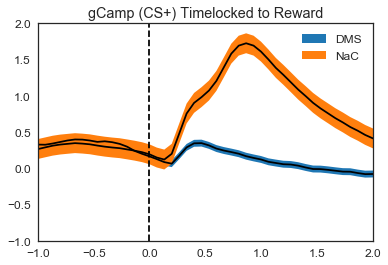

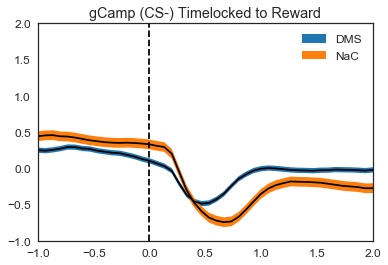

In [54]:
df_trials_ch = df_trials.sort_values('choice_i')

_g_reward = np.vstack(df_trials[df_trials['Reward'] == 1]['g_reward'])
x = np.arange(-LEN_BEFORE_R/15, LEN_AFTER_R/ 15, 1/15)
y = np.mean(_g_reward, axis = 0)
error = np.std(y, axis = 0) / np.sqrt(NS)

plt.ylim([-1, 2])
plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error, label = 'DMS')

_g_reward2 = np.vstack(df_trials_NaC[df_trials_NaC['Reward'] == 1]['g_reward'])
x = np.arange(-LEN_BEFORE_R/15, LEN_AFTER_R/ 15, 1/15)
y = np.mean(_g_reward2, axis = 0)
error = np.std(y, axis = 0) / np.sqrt(NS)

plt.ylim([-1, 2])
plt.xlim([-1, 2])

plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error,  label = 'NaC')
plt.axvline(0, color = 'k', linestyle='--')


plt.title('gCamp (CS+) Timelocked to Reward')
plt.legend()


plt.figure()
df_trials_ch = df_trials.sort_values('choice_i')

_g_reward = np.vstack(df_trials[df_trials['Reward'] == 0]['g_reward'])
y = np.mean(_g_reward, axis = 0)
error = np.std(y, axis = 0) / np.sqrt(NS)


plt.plot(x, y, 'k-')
plt.ylim([-1, 2])
plt.xlim([-1, 2])

plt.fill_between(x, y-error, y+error, label = 'DMS')

_g_reward2 = np.vstack(df_trials_NaC[df_trials_NaC['Reward'] == 0]['g_reward'])
y = np.mean(_g_reward2, axis = 0)
error = np.std(y, axis = 0) / np.sqrt(NS)

plt.ylim([-1, 2])

plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error, label = 'NaC')

plt.axvline(0, color = 'k', linestyle='--')
plt.legend()

plt.xlim([-1, 2])

plt.title('gCamp (CS-) Timelocked to Reward')



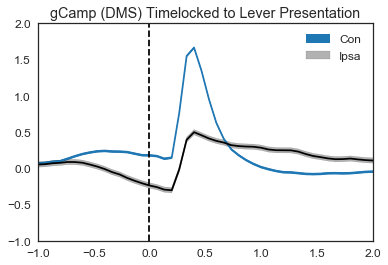

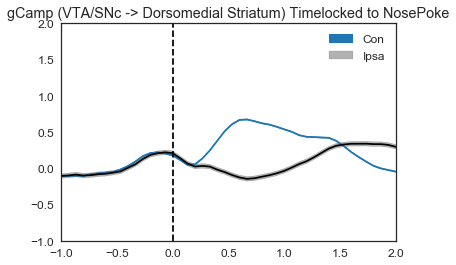

In [56]:
fig = plt.figure()

# add to the code above to encode when the lever choice occurs. you'll want to 

_g_reward = np.vstack(df_trials[df_trials['Action'] == 'Con']['g_lp'])

x = np.arange(-LEN_BEFORE_R/15, LEN_AFTER_R/ 15, 1/15)
y = np.mean(_g_reward, axis = 0)
error = np.var(y, axis = 0) / np.sqrt(NS)


plt.plot(x, y, '-')
plt.fill_between(x, y-error, y+error, label = 'Con')

_g_reward = np.vstack(df_trials[df_trials['Action'] == 'Ips']['g_lp'])

y = np.mean(_g_reward, axis = 0)
error = np.std(y, axis = 0) / np.sqrt(NS)


plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error,  color = 'k', label = 'Ipsa', alpha = 0.3)

plt.axvline(0, color = 'k', linestyle='--')

plt.xlim([-1, 2])
plt.ylim([-1, 2])
plt.legend()
plt.title('gCamp (DMS) Timelocked to Lever Presentation')


fig = plt.figure()

# add to the code above to encode when the lever choice occurs. you'll want to 


_g_reward = np.vstack(df_trials[df_trials['Action'] == 'Con']['g_np'])
y = np.mean(_g_reward, axis = 0)
error = np.var(y, axis = 0)/ np.sqrt(NS)


plt.plot(x, y, '-')
plt.fill_between(x, y-error, y+error, label = 'Con')

_g_reward = np.vstack(df_trials[df_trials['Action'] == 'Ips']['g_np'])

y = np.mean(_g_reward, axis = 0)
error = np.std(y, axis = 0)/ np.sqrt(NS)


plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error,  color = 'k', label = 'Ipsa', alpha = 0.3)

plt.axvline(0, color = 'k', linestyle='--')

plt.xlim([-1, 2])
plt.ylim([-1, 2])
plt.legend()

plt.title('gCamp (VTA/SNc -> Dorsomedial Striatum) Timelocked to NosePoke')


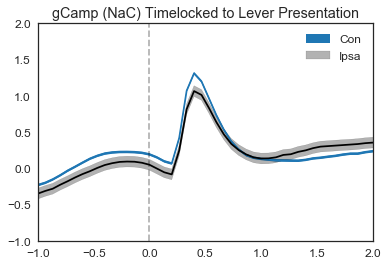

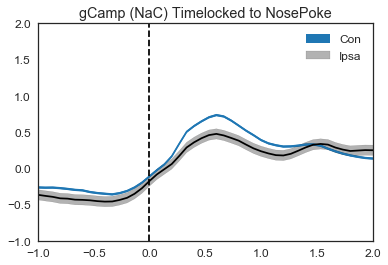

In [58]:
fig = plt.figure()

# add to the code above to encode when the lever choice occurs. you'll want to 

_g_reward = np.vstack(df_trials_NaC[df_trials_NaC['Action'] == 'Con']['g_lp'])

x = np.arange(-LEN_BEFORE_R/15, LEN_AFTER_R/ 15, 1/15)
y = np.mean(_g_reward, axis = 0)
error = np.var(y, axis = 0) / np.sqrt(NS)


plt.plot(x, y, '-')
plt.fill_between(x, y-error, y+error, label = 'Con')

_g_reward = np.vstack(df_trials_NaC[df_trials_NaC['Action'] == 'Ips']['g_lp'])

y = np.mean(_g_reward, axis = 0)
error = np.std(y, axis = 0) / np.sqrt(NS)


plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error,  color = 'k', label = 'Ipsa', alpha = 0.3)

plt.axvline(0, color = 'k', linestyle='--', alpha = 0.3)

plt.xlim([-1,2])
plt.ylim([-1, 2])
plt.legend()
plt.title('gCamp (NaC) Timelocked to Lever Presentation')


fig = plt.figure()

# add to the code above to encode when the lever choice occurs. you'll want to 


_g_reward = np.vstack(df_trials_NaC[df_trials_NaC['Action'] == 'Con']['g_np'])
y = np.mean(_g_reward, axis = 0)
error = np.var(y, axis = 0)/ np.sqrt(NS)


plt.plot(x, y, '-')
plt.fill_between(x, y-error, y+error, label = 'Con')

_g_reward = np.vstack(df_trials_NaC[df_trials_NaC['Action'] == 'Ips']['g_np'])

y = np.mean(_g_reward, axis = 0)
error = np.std(y, axis = 0)/ np.sqrt(NS)


plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error,  color = 'k', label = 'Ipsa', alpha = 0.3)

plt.axvline(0, color = 'k', linestyle='--')

plt.xlim([-1, 2])
plt.ylim([-1, 2])
plt.legend()

plt.title('gCamp (NaC) Timelocked to NosePoke')


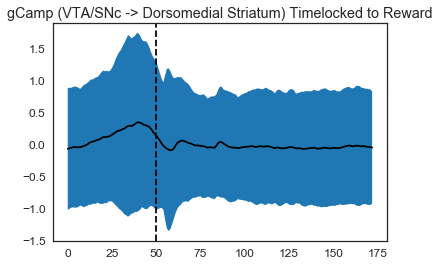

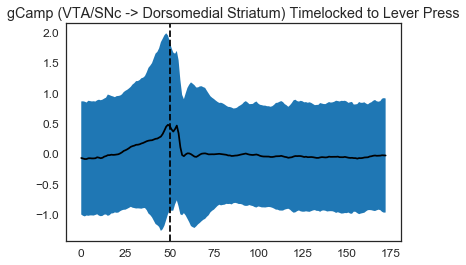

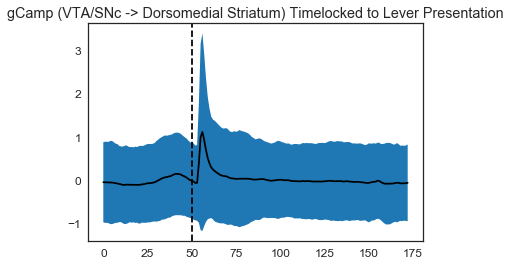

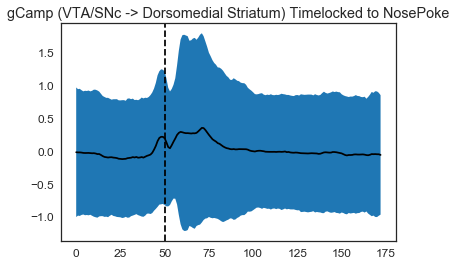

In [15]:
# add to the code above to encode when the lever choice occurs. you'll want to 

df_trials_ch = df_trials.sort_values('choice_i')

_g_reward = np.vstack(df_trials_ch['g_reward'])
x = np.arange(LEN_AFTER_R + LEN_BEFORE_R)
y = np.mean(_g_reward, axis = 0)
error = np.var(_g_reward, axis = 0)


plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error)
plt.axvline(LEN_BEFORE_R, color = 'k', linestyle='--')

plt.title('gCamp (VTA/SNc -> Dorsomedial Striatum) Timelocked to Reward')

fig = plt.figure()

# add to the code above to encode when the lever choice occurs. you'll want to 

df_trials_ch = df_trials.sort_values('lp_i')

_g_reward = np.vstack(df_trials_ch['g_choice'])
x = np.arange(LEN_AFTER_C + LEN_BEFORE_C)
y = np.mean(_g_reward, axis = 0)
error = np.var(_g_reward, axis = 0)


plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error)
plt.axvline(LEN_BEFORE_R, color = 'k', linestyle='--')

plt.title('gCamp (VTA/SNc -> Dorsomedial Striatum) Timelocked to Lever Press')

fig = plt.figure()

# add to the code above to encode when the lever choice occurs. you'll want to 

df_trials_ch = df_trials.sort_values('np_i')

_g_reward = np.vstack(df_trials_ch['g_lp'])
x = np.arange(LEN_AFTER_C + LEN_BEFORE_C)
y = np.mean(_g_reward, axis = 0)
error = np.var(_g_reward, axis = 0)


plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error)
plt.axvline(LEN_BEFORE_R, color = 'k', linestyle='--')

plt.title('gCamp (VTA/SNc -> Dorsomedial Striatum) Timelocked to Lever Presentation')


fig = plt.figure()

# add to the code above to encode when the lever choice occurs. you'll want to 

df_trials_ch = df_trials.sort_values('tstart_i')

_g_reward = np.vstack(df_trials_ch['g_np'])
x = np.arange(LEN_AFTER_C + LEN_BEFORE_C)
y = np.mean(_g_reward, axis = 0)
error = np.var(_g_reward, axis = 0)


plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error)
plt.axvline(LEN_BEFORE_R, color = 'k', linestyle='--')

plt.title('gCamp (VTA/SNc -> Dorsomedial Striatum) Timelocked to NosePoke')


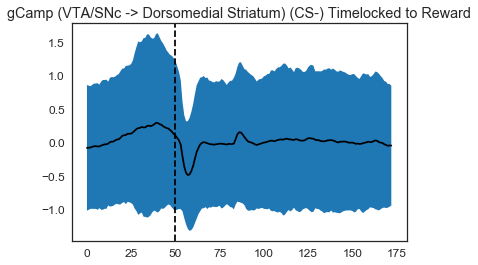

In [56]:
df_trials.head()

,MouseID,Trial,Action,Reward,Stay/Leave,tstart_i,g_np,np_i,g_lp,lp_i,g_choice,choice_i,g_reward
0,0,0,Con,1,N/A,1336,"[0.96554798571, 0.20837263566, -0.170896069074...",41,"[0.10906756724, 0.406991309065, 0.616334015199...",29,"[0.0245789881784, 0.779923135595, 1.7712496795...",47,"[2.45977436134, 2.10485710077, 0.609201069567,..."
1,0,1,Con,0,stay,82,"[0.455825134123, 0.213146999533, 0.06853407700...",34,"[1.69131603912, 1.21414991759, 0.219036283531,...",-28,"[-1.07118646706, -1.03756285943, -1.1250010114...",49,"[-1.03756285943, -1.12500101144, -0.858547594,..."
2,0,2,Con,0,stay,-26,"[0.814235229361, 0.465909498074, 0.32999217355...",44,"[-0.910515991409, -1.41119056427, -1.163423580...",28,"[-0.965594390716, -0.614732833656, 0.123613335...",48,"[0.12361333517, 1.02139226291, 1.68147470295, ..."
3,0,3,Con,0,stay,-31,"[0.837084107717, 0.73893134182, 0.606371321467...",46,"[-0.321827946378, -0.53473943409, -0.627775030...",31,"[-0.710953960229, -0.835756005256, -0.57415710...",47,"[-0.20965712446, -0.0915932940002, -0.33537595..."
4,0,4,Con,0,stay,-22,"[-1.04014426959, -1.07131829079, -1.2372417534...",36,"[-0.620268376844, -0.768172140344, -0.57274994...",29,"[0.60463664226, 0.377300819673, 0.545629739255...",36,"[-0.323515416702, -0.216447962411, -0.12516896..."


In [66]:
LEN_BEFORE 

30

In [48]:
np.shape(foo)

(1546371,)

#### first pass of timelocking gcamp respone

In [ ]:
def avgNestedLists(nested_vals):
    """
    Averages a 2-D array and returns a 1-D array of all of the columns
    averaged together, regardless of their dimensions.
    """
    output = []
    maximum = 0
    for lst in nested_vals:
        if len(lst) > maximum:
            maximum = len(lst)
    for index in range(maximum): # Go through each index of longest list
        temp = []
        for lst in nested_vals: # Go through each list
            if index < len(lst): # If not an index error
                temp.append(lst[index])
        output.append(np.nanmean(temp))
    return output

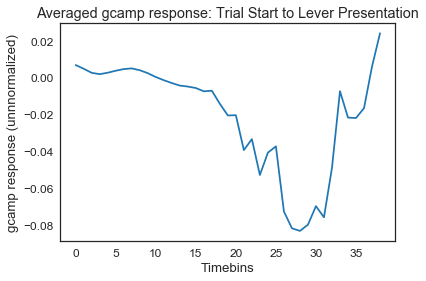

In [136]:
# for s in np.arange(NS): 

plt.plot(avgNestedLists(df_trials['g_pre_lever']))
plt.title('Averaged gcamp response: Trial Start to Lever Presentation')
plt.xlabel('Timebins')
plt.ylabel('gcamp response (unnnormalized)')

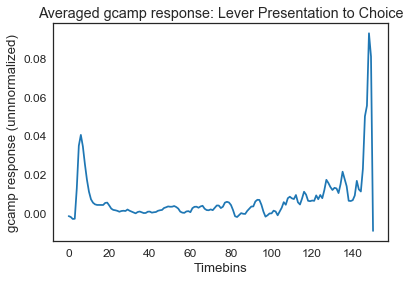

In [137]:
plt.plot(avgNestedLists(df_trials['g_pre_choice']))
plt.title('Averaged gcamp response: Lever Presentation to Choice')
plt.xlabel('Timebins')
plt.ylabel('gcamp response (unnnormalized)')

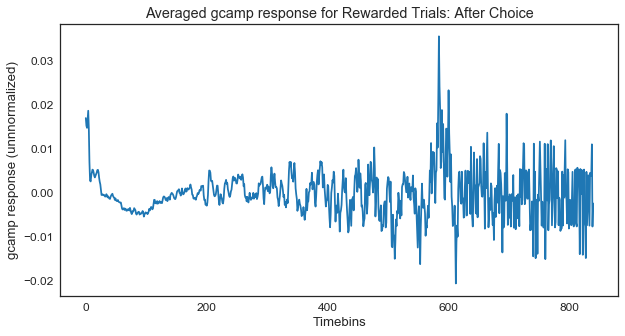

In [141]:
fig = plt.figure(figsize=(10,5))
plt.plot(avgNestedLists(df_trials[df_trials['Reward'] == 1]['g_post_choice']))
plt.title('Averaged gcamp response for Rewarded Trials: After Choice')
plt.xlabel('Timebins')
plt.ylabel('gcamp response (unnnormalized)')

In [89]:
bin_len = [len(x) for x in df_trials['g_post_choice']]
bin_len_r = [len(x) for x in df_trials[df_trials['Reward'] == 1]['g_post_choice']]
lt = lambda x: x < 5000
bin_len = list(filter(lt, bin_len))
bin_len_nr = [len(x) for x in df_trials[df_trials['Reward'] == 0]['g_post_choice']]
bin_len_nr = list(filter(lt, bin_len_nr))


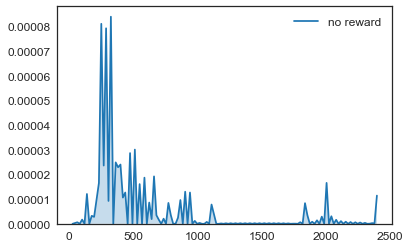

In [92]:
# sns.kdeplot(bin_len, shade=True, label = 'all')
sns.kdeplot(bin_len_nr, shade=True, label = 'no reward')
# sns.kdeplot(bin_len_r, shade=True, label = 'reward')


In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(avgNestedLists(df_trials[df_trials['Reward'] == 0]['g_post_choice']))
plt.title('Averaged gcamp response for unrewarded Trials: After Choice')
plt.xlabel('Timebins')
plt.ylabel('gcamp response (unnnormalized)')